# Visualization of phylodynamics inference results

In this notebook, we will introduce how to visualize scPhyloX inference and analysis results

In [1]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import gzip
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import pickle
from scipy.integrate import quad, solve_ivp
from scipy.stats import poisson, chisquare
import os

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12

In [3]:
os.chdir('../..')

First, we import the data and scPhyloX inference results. The point estimates of each parameter will be saved in `theta_h`

In [4]:
idata = pickle.load(open('datasets/simulation/overshoot/para_inf.pkl', 'rb'))
idata_bl = pickle.load(open('datasets/simulation/overshoot/mutrate_inf.pkl', 'rb'))
theta_h = az.summary(idata).loc['ax,bx,r,d,k,t0'.split(',')]['mean'].to_numpy()

/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [5]:
with gzip.open('datasets/simulation/overshoot/character_matrix.csv.gz', 'rb') as f:
    charater_matrix = pd.read_csv(f, index_col=0)
charater_matrix = charater_matrix.to_numpy()
with gzip.open('datasets/simulation/overshoot/simulation_data.csv.gz', 'rb') as f:
    ground_truth = pd.read_csv(f, index_col=0)
ground_truth = ground_truth.to_numpy()
ground_truth = ground_truth[np.arange(0, ground_truth.shape[0], 1000)]
time = ground_truth[:, 0]
cell_number = ground_truth[:, 1:]

In [6]:
mutnum = spx.data_factory.get_mutnum(charater_matrix)
branch_len = spx.data_factory.get_branchlen(charater_matrix)

100%|██████████| 125250/125250 [00:04<00:00, 25575.91it/s]


Here, we can inference the number of stem and non-stem cells changes over time in different generations, that is, the tissue development history could be revealed.

In [7]:
T = 35
n_stem = np.array([[spx.est_tissue.ncyc(i, j, 100, *theta_h) for j in range(T)] for i in range(100)])
n_nonstem = np.array([[spx.est_tissue.nnc(i, j, 100, *theta_h) for j in range(T)] for i in range(100)])

Text(0, 0.5, 'Cell number')

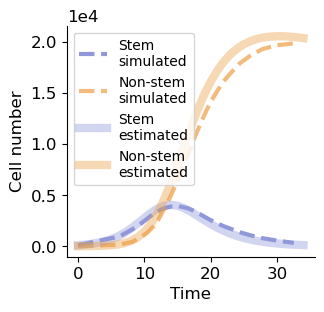

In [8]:
fig, ax = plt.subplots(figsize=(3.2, 3))
ax.plot(time, cell_number[:, 0], '--', lw=3, label='Stem\nsimulated', c='#9098d9')
ax.plot(time, cell_number[:, 1], '--', lw=3, label='Non-stem\nsimulated', c='#ed9e44', alpha=0.7)
ax.plot(range(T), n_stem.sum(0), label='Stem\nestimated', c='#9098d9', lw=6, alpha=0.4)
ax.plot(range(T), n_nonstem.sum(0), label='Non-stem\nestimated', c='#ed9e44', lw=6, alpha=0.4)
ax.legend(loc=2,fontsize=10)
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')

Accurate fitting of LP and LR distance distributions can illustrate the accuracy of the inference

lp_Power_divergenceResult(statistic=0.13853071748300083, pvalue=0.999638361551232)
lr_Power_divergenceResult(statistic=0.008769196264595613, pvalue=0.9997821707208558)


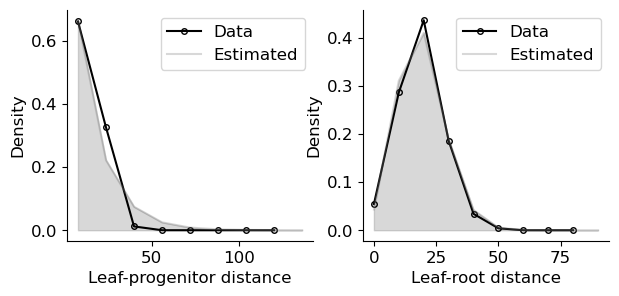

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

max_val = 130
n_hist = 8
xrange = np.arange(0, max_val, int(max_val/n_hist))+int(max_val/n_hist)/2
dist = np.histogram(branch_len+1, xrange-int(max_val/n_hist)/2)
th_dist = [spx.est_mr.BranchLength(*az.summary(idata_bl)['mean']).prob(i) for i in xrange]
    
ax[0].plot(xrange[:-1], dist[0]/sum(dist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[0].plot(xrange, th_dist/sum(th_dist), c='tab:grey',alpha=0.3, label='Estimated')
ax[0].fill_between(xrange, th_dist/sum(th_dist), color='tab:grey', alpha=0.3)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Leaf-progenitor distance')
ax[0].set_ylabel('Density')
ax[0].legend()
print(f'lp_{chisquare(f_obs = dist[0]/sum(dist[0]), f_exp=th_dist[:-1]/sum(th_dist[:-1]), ddof=2)}')



alpha = n_stem[:,-1]+n_nonstem[:,-1]
alpha = alpha / sum(alpha)

max_val = 100
n_hist = 10
mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
th_dist = np.zeros(max_val)
for i, a in enumerate(alpha):
    th_dist = th_dist + a*poisson((i+1)*2).pmf(range(max_val))
th_dist_x = []
th_dist_y = []
for i in range(n_hist):
    th_dist_x.append(i*int(max_val/n_hist))
    th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
ax[1].plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[1].plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Estimated')
ax[1].fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('Leaf-root distance')
ax[1].set_ylabel('Density')
ax[1].legend()
print(f'lr_{chisquare(f_obs = mutdist[0]/sum(mutdist[0]), f_exp=th_dist_y[:-1]/sum(th_dist_y[:-1]), ddof=5)}')